# 3.2 线性回归的从零开始实现

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.3.0


## 3.2.1 生成数据集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4]).view(2, -1)
true_b = torch.tensor(4.2)
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
#                        dtype=torch.float32)
labels += torch.tensor(np.random.normal(0, 0.01), dtype=torch.float32)

In [3]:
print(features.shape)
print(labels.size())

torch.Size([1000, 2])
torch.Size([1000])


In [4]:
print(features[0], labels[0])
print(features[-1], labels[-1])

tensor([ 0.2983, -0.9819]) tensor(8.1361)
tensor([-1.3512, -0.7080]) tensor(3.9058)


In [5]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        The data positions.
    
    s : scalar or array_like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of color, optional
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of color specifications of length n.
        - A sequence of n numbers to be mapped to colors using *cmap* and
          *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single numeric RGB or RGBA sequen

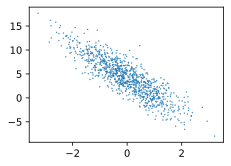

In [6]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
# plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
plt.scatter(features[:, 1].numpy(), labels.numpy(), 0.2)

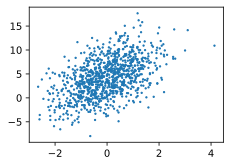

In [7]:
set_figsize()
# plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
plt.scatter(features[:, 0].numpy(), labels.numpy(), 2)

## 3.2.2 读取数据

In [8]:
help(random.shuffle)

Help on method shuffle in module random:

shuffle(x, random=None) method of random.Random instance
    Shuffle list x in place, and return None.
    
    Optional argument random is a 0-argument function returning a
    random float in [0.0, 1.0); if it is the default None, the
    standard random.random will be used.



In [9]:
x = list(range(10))
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [10]:
random.shuffle(x)
print(x)

[0, 9, 5, 6, 2, 7, 3, 8, 1, 4]


In [11]:
num_examples = len(features)
batch_size = 10
print(list(range(0, num_examples, batch_size)))
print(len(list(range(0, num_examples, batch_size))))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]
100


In [12]:
# See https://pytorch.org/docs/stable/tensors.html for LongTensor

In [13]:
help(torch.index_select)

Help on built-in function index_select:

index_select(...)
    index_select(input, dim, index, out=None) -> Tensor
    
    Returns a new tensor which indexes the :attr:`input` tensor along dimension
    :attr:`dim` using the entries in :attr:`index` which is a `LongTensor`.
    
    The returned tensor has the same number of dimensions as the original tensor
    (:attr:`input`).  The :attr:`dim`\ th dimension has the same size as the length
    of :attr:`index`; other dimensions have the same size as in the original tensor.
    
    .. note:: The returned tensor does **not** use the same storage as the original
              tensor.  If :attr:`out` has a different shape than expected, we
              silently change it to the correct shape, reallocating the underlying
              storage if necessary.
    
    Args:
        input (Tensor): the input tensor.
        dim (int): the dimension in which we index
        index (LongTensor): the 1-D tensor containing the indices to index


In [14]:
indices = list(range(num_examples))
random.shuffle(indices) 
print(indices[:10])

[391, 984, 324, 511, 256, 621, 649, 575, 736, 857]


In [15]:
i = 0
j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
print(j)

tensor([391, 984, 324, 511, 256, 621, 649, 575, 736, 857])


In [16]:
i = 10
j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
print(j)

tensor([449, 699, 880, 303, 691, 711, 436, 918, 274, 197])


See https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do to understand `yield` statement.

In [17]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [18]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.8789,  0.3089],
        [-1.5327, -0.6424],
        [-0.8585,  1.1835],
        [-0.6606, -0.2289],
        [-1.0755, -0.2193],
        [-0.4535,  1.4533],
        [-0.7193,  0.4140],
        [ 1.3537,  0.1834],
        [ 0.3779,  0.6867],
        [-1.0961,  2.0918]]) 
 tensor([ 1.3929,  3.3195, -1.5398,  3.6582,  2.7957, -1.6473,  1.3547,  6.2847,
         2.6220, -5.1035])


## 3.2.3 初始化模型参数

In [19]:
help(torch.randn)

Help on built-in function randn:

randn(...)
    randn(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor
    
    Returns a tensor filled with random numbers from a normal distribution
    with mean `0` and variance `1` (also called the standard normal
    distribution).
    
    .. math::
        \text{out}_{i} \sim \mathcal{N}(0, 1)
    
    The shape of the tensor is defined by the variable argument :attr:`size`.
    
    Args:
        size (int...): a sequence of integers defining the shape of the output tensor.
            Can be a variable number of arguments or a collection like a list or tuple.
        out (Tensor, optional): the output tensor.
        dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
            Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
        layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
            De

In [20]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

In [21]:
w, b

(tensor([[0.0151],
         [0.0095]], requires_grad=True), tensor([0.], requires_grad=True))

In [22]:
w.requires_grad, b.requires_grad

(True, True)

In [23]:
# w.requires_grad_(requires_grad=True)
# b.requires_grad_(requires_grad=True) 

## 3.2.4 定义模型

In [24]:
help(torch.mm)

Help on built-in function mm:

mm(...)
    mm(input, mat2, out=None) -> Tensor
    
    Performs a matrix multiplication of the matrices :attr:`input` and :attr:`mat2`.
    
    If :attr:`input` is a :math:`(n \times m)` tensor, :attr:`mat2` is a
    :math:`(m \times p)` tensor, :attr:`out` will be a :math:`(n \times p)` tensor.
    
    .. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
              For broadcasting matrix products, see :func:`torch.matmul`.
    
    Args:
        input (Tensor): the first matrix to be multiplied
        mat2 (Tensor): the second matrix to be multiplied
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> mat1 = torch.randn(2, 3)
        >>> mat2 = torch.randn(3, 3)
        >>> torch.mm(mat1, mat2)
        tensor([[ 0.4851,  0.5037, -0.3633],
                [-0.0760, -3.6705,  2.4784]])



In [25]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [26]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
#     return (y_hat - y.view(y_hat.size())) ** 2 / 2
    return (y_hat - y.view(y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法

In [27]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [28]:
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 2.185239
epoch 2, loss 0.284809
epoch 3, loss 0.037327
epoch 4, loss 0.004916
epoch 5, loss 0.000651
epoch 6, loss 0.000087
epoch 7, loss 0.000012
epoch 8, loss 0.000002
epoch 9, loss 0.000000
epoch 10, loss 0.000000


In [29]:
print(true_w, '\n', w)
print(true_b, '\n', b)

tensor([[ 2.0000],
        [-3.4000]]) 
 tensor([[ 1.9999],
        [-3.3999]], requires_grad=True)
tensor(4.2000) 
 tensor([4.2008], requires_grad=True)
